# Fake News Classification 

A text classification model is trained to detect fake news articles.

In [3]:
# mount drive on Colab to access dataset
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


## Import Libraries



In [1]:
import numpy as np
import pandas as pd
import pickle
import matplotlib.pyplot as plt
import seaborn as sns

# for Text Processing
import nltk
import re

# for Word Embedding Word2Vec
from gensim.models import Word2Vec

# for Neural Network
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Embedding, LSTM, Conv1D, MaxPool1D, Dropout


from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score, roc_curve, auc

## Dataset loading, EDA and Preprocessing

In [8]:
# read csv datasets
fake = pd.read_csv('/content/gdrive/MyDrive/Goddard/news-dataset/Fake.csv')
real = pd.read_csv('/content/gdrive/MyDrive/Goddard/news-dataset/True.csv')

In [9]:
fake.head()

,title,text,subject,date
0,Donald Trump Sends Out Embarrassing New Year’...,Donald Trump just couldn t wish all Americans ...,News,"December 31, 2017"
1,Drunk Bragging Trump Staffer Started Russian ...,House Intelligence Committee Chairman Devin Nu...,News,"December 31, 2017"
2,Sheriff David Clarke Becomes An Internet Joke...,"On Friday, it was revealed that former Milwauk...",News,"December 30, 2017"
3,Trump Is So Obsessed He Even Has Obama’s Name...,"On Christmas day, Donald Trump announced that ...",News,"December 29, 2017"
4,Pope Francis Just Called Out Donald Trump Dur...,Pope Francis used his annual Christmas Day mes...,News,"December 25, 2017"


In [10]:
real.tail()

,title,text,subject,date
21412,'Fully committed' NATO backs new U.S. approach...,BRUSSELS (Reuters) - NATO allies on Tuesday we...,worldnews,"August 22, 2017"
21413,LexisNexis withdrew two products from Chinese ...,"LONDON (Reuters) - LexisNexis, a provider of l...",worldnews,"August 22, 2017"
21414,Minsk cultural hub becomes haven from authorities,MINSK (Reuters) - In the shadow of disused Sov...,worldnews,"August 22, 2017"
21415,Vatican upbeat on possibility of Pope Francis ...,MOSCOW (Reuters) - Vatican Secretary of State ...,worldnews,"August 22, 2017"
21416,Indonesia to buy $1.14 billion worth of Russia...,JAKARTA (Reuters) - Indonesia will buy 11 Sukh...,worldnews,"August 22, 2017"


In [11]:
print(fake.info())
print(real.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23481 entries, 0 to 23480
Data columns (total 4 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   title    23481 non-null  object
 1   text     23481 non-null  object
 2   subject  23481 non-null  object
 3   date     23481 non-null  object
dtypes: object(4)
memory usage: 733.9+ KB
None
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21417 entries, 0 to 21416
Data columns (total 4 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   title    21417 non-null  object
 1   text     21417 non-null  object
 2   subject  21417 non-null  object
 3   date     21417 non-null  object
dtypes: object(4)
memory usage: 669.4+ KB
None


In [12]:
# create target variable in real and fake data
fake['output'] = 0
real['output'] = 1

In [13]:
# in real data text column has publisher given, remove it so that model does not train on publisher info.
for index,row in enumerate(real.text.values):
    try:
        record = row.split(" -", maxsplit=1)
        real.iloc[index, 1] = record[1]
    except:
        real.iloc[index, 1] = row

In [14]:
# check for empty text in real data and drop it. Not required for fake.
real_empty_indexes = [index for index,text in enumerate(real.text.values) if str(text).strip() == '']
real = real.drop(real_empty_indexes, axis=0)

In [15]:
# Combine text and title
real["text"] = real["title"] + " " + real["text"]
fake["text"] = fake["title"] + " " + fake["text"]

# then drop all columns except text and output
real = real.drop(["subject", "date","title"], axis=1)
fake = fake.drop(["subject", "date", "title"], axis=1)

In [16]:
# Combine real and fake
news = pd.concat([fake, real])
print(news.info())
news.head()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 44897 entries, 0 to 21416
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   text    44897 non-null  object
 1   output  44897 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 1.0+ MB
None


,text,output
0,Donald Trump Sends Out Embarrassing New Year’...,0
1,Drunk Bragging Trump Staffer Started Russian ...,0
2,Sheriff David Clarke Becomes An Internet Joke...,0
3,Trump Is So Obsessed He Even Has Obama’s Name...,0
4,Pope Francis Just Called Out Donald Trump Dur...,0


## Text Processing

In [ ]:
# download stopwords and tokenizer if error in next cell, else no need to run this
nltk.download('stopwords')
nltk.download('punkt')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [ ]:
y = news['output'].values
X = []
# remove stopwords, convert to lowercase and tokenize each sentence in each row
stop_words = set(nltk.corpus.stopwords.words("english"))
data = news['text'].apply(lambda x: ' '.join([word.lower() for word in x.split() if word not in stop_words or len(word) > 1]))

for row in data:
  temp = []

  sentence = nltk.sent_tokenize(row)
  for word in sentence:
    w = nltk.word_tokenize(word)
    temp.extend(w)

  X.append(temp)

In [ ]:
EMB_DIM = 50

# Word Embedding
w2v = Word2Vec(sentences=X, size=EMB_DIM, window=5, min_count=1)

In [ ]:
len(w2v.wv.vocab)

231120

In [ ]:
# Tokenize input using module provided by Tensorflow
tokenizer = Tokenizer()
tokenizer.fit_on_texts(X)

X = tokenizer.texts_to_sequences(X)

In [ ]:
# set max length of input
maxlen = 750
# pad extra length by 0 or cut off length at 750
X = pad_sequences(X, maxlen=maxlen)
vocab_size = len(tokenizer.word_index) + 1

## Neural Network

In [ ]:
model = Sequential()
model.add(Embedding(vocab_size, output_dim = EMB_DIM,input_length = maxlen))
model.add(Dropout(0.3))
model.add(LSTM(128))
model.add(Dropout(0.3))
model.add(Dense(1,activation='sigmoid'))

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['acc'])

In [ ]:
model.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_4 (Embedding)      (None, 750, 50)           11556050  
_________________________________________________________________
dropout_6 (Dropout)          (None, 750, 50)           0         
_________________________________________________________________
lstm_3 (LSTM)                (None, 128)               91648     
_________________________________________________________________
dropout_7 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 129       
Total params: 11,647,827
Trainable params: 11,647,827
Non-trainable params: 0
_________________________________________________________________


In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42) 

In [ ]:
model.fit(X_train, y_train, validation_split=0.3, epochs=6, batch_size=128)

Epoch 1/6
165/165 [==============================] - 34s 197ms/step - loss: 0.2958 - acc: 0.8989 - val_loss: 0.1980 - val_acc: 0.9318
Epoch 2/6
165/165 [==============================] - 30s 184ms/step - loss: 0.1218 - acc: 0.9505 - val_loss: 0.0816 - val_acc: 0.9648
Epoch 3/6
165/165 [==============================] - 31s 188ms/step - loss: 0.0249 - acc: 0.9924 - val_loss: 0.0525 - val_acc: 0.9834
Epoch 4/6
165/165 [==============================] - 31s 186ms/step - loss: 0.0103 - acc: 0.9977 - val_loss: 0.0307 - val_acc: 0.9902
Epoch 5/6
165/165 [==============================] - 32s 192ms/step - loss: 0.0045 - acc: 0.9993 - val_loss: 0.0325 - val_acc: 0.9908
Epoch 6/6
165/165 [==============================] - 31s 187ms/step - loss: 0.0030 - acc: 0.9994 - val_loss: 0.0287 - val_acc: 0.9912


In [ ]:
# save model
model.save('/content/gdrive/MyDrive/Goddard/news_model.h5')

# save tokenizer
with open('/content/gdrive/MyDrive/Goddard/tokenizer.pickle', 'wb') as handle:
  pickle.dump(tokenizer, handle, protocol=pickle.HIGHEST_PROTOCOL)

## Testing and Accuracy

In [ ]:
y_pred = (model.predict(X_test) >= 0.5).astype("int")
accuracy_score(y_test, y_pred)

0.9925760950259837

In [ ]:
fpr, tpr, thresholds = roc_curve(y_test, y_pred)
auc = auc(fpr, tpr)

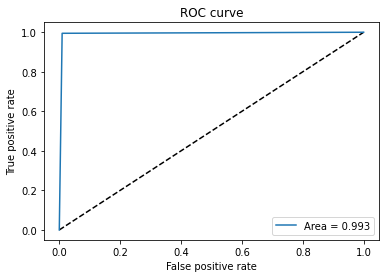

In [ ]:
plt.figure(1)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr, tpr, label='Area = {:.3f}'.format(auc))
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='best')
plt.show()

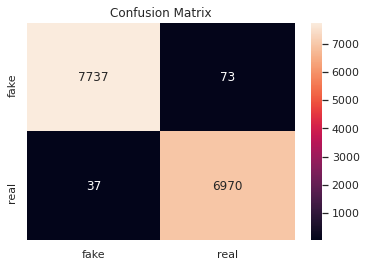

In [ ]:
array = confusion_matrix(y_test, y_pred)
ax= plt.subplot()
sns.heatmap(array, annot=True, fmt='g', ax=ax)
ax.set_title('Confusion Matrix')
ax.xaxis.set_ticklabels(['fake', 'real'])
ax.yaxis.set_ticklabels(['fake', 'real'])

plt.show()

## To test your own news

In [4]:
# load model and tokenizer
def load_model_tokenizer(path):
  with open(path + 'tokenizer.pickle', 'rb') as handle:
    tokenizer = pickle.load(handle)

  news_model = tf.keras.models.load_model(path + 'news_model.h5')

  return tokenizer, news_model

In [5]:
# prediction function
def predict_news(text, model, tokenizer):
  t = tokenizer.texts_to_sequences([text])
  t = pad_sequences(t, maxlen=750)

  pred = (model.predict(t) >= 0.5).astype("int")

  ans = "real" if pred[0][0] else "fake"

  return ans

In [6]:
tokenizer, news_model = load_model_tokenizer("/content/gdrive/MyDrive/Goddard/")

In [17]:
test = news.iloc[30000, 0]
test_y = news.iloc[30000,1]
test_ans = 'real' if test_y == 1 else 'fake'
print(f'Prediction: {predict_news(test, news_model, tokenizer)}')
print(f'Original: {test_ans}')

Prediction: real
Original: real


In [18]:
# testing using fake news from internet
test = "WNDR shall not be responsible for any incorrect or inaccurate information, whether caused by website users or by any of the equipment or programming associated with or utilized in this website or by any technical or human error which may occur.  WNDR assumes however all responsibility for the satirical nature of its articles and for the fictional nature of their content. All characters appearing in the articles in this website – even those based on real people –  are entirely fictional and any resemblance between them and any persons, living, dead, or undead is purely a miracle."
print(f'Prediction: {predict_news(test, news_model, tokenizer)}')

Prediction: fake


In [19]:
test = "NYC coroner who declared the death of Jeffrey Epstein a suicide made half a million dollars a year working for the Clinton Foundation until 2015"
print(f'Prediction: {predict_news(test, news_model, tokenizer)}')

Prediction: fake
